[The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0)

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# First example

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5
f(3)

20

In [3]:
xs = np.arange(-5, 5, 0.1)
ys = f(xs)

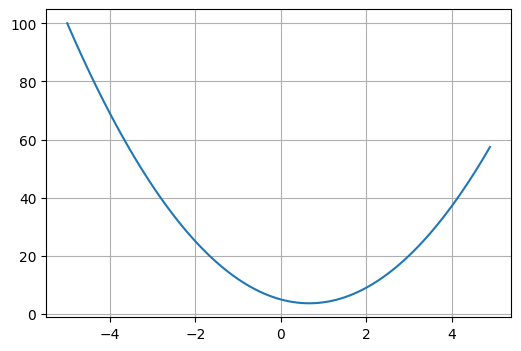

In [4]:
plt.figure(figsize=(6, 4))
plt.plot(xs, ys)
plt.grid()

In [5]:
h = 0.001
x = 3
df = (f(x+h)-f(x))/h
df

14.00300000000243

In [6]:
def df_dx(x):
    return 6*x - 4

df_dx(x)

14

## plotting derivative as a line tangent to the function

In [7]:
l_size = 2
x = 3
y = f(x)
a = df_dx(x)
b = y - a*x
l_xs = np.array([x-l_size, x+l_size])
l_ys = a*l_xs + b

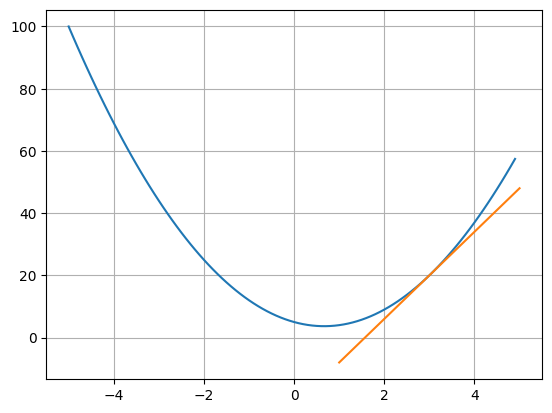

In [8]:
plt.plot(xs, ys)
plt.plot(l_xs, l_ys)
plt.grid()

# Second Example

In [9]:
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
print(f'{d1=}')

d1=4.0


In [10]:
h = 0.001

d2 = (a+h)*b + c
print(f'{d2=}')
df_da = (d2-d1)/h
print(f'{df_da=}\n')

d3 = a*(b+h) + c
print(f'{d3=}')
df_db = (d3-d1)/h
print(f'{df_db=}\n')

d4 = a*b + (c+h)
print(f'{d4=}')
df_dc = (d4-d1)/h
print(f'{df_dc=}\n')

d2=3.997
df_da=-3.0000000000001137

d3=4.002
df_db=1.9999999999997797

d4=4.0009999999999994
df_dc=0.9999999999994458



# Value class

In [11]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        n = self.data
        e_pow_x = math.exp(2*n)
        t = (e_pow_x - 1)/(e_pow_x + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def get_topo(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        return topo

    def backward(self):
        topo = self.get_topo()
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [14]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'

### function for displaying operations as graph

In [15]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = f" {n.label} | data={n.data:.4f} | grad={n.grad:.4f} ", shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

### continue

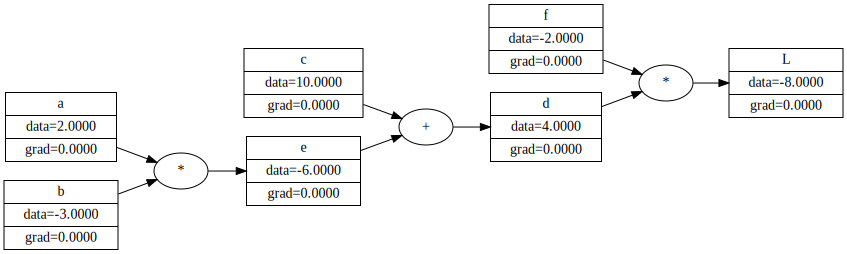

In [16]:
draw_dot(L)

### manual backward pass

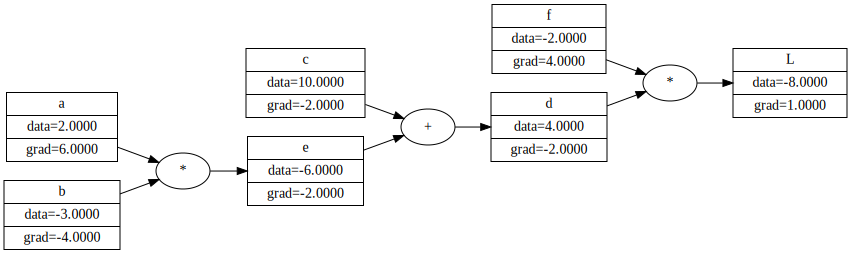

In [17]:
L.grad = 1.0  # dL / dL - linear dependency which is obvious
f.grad = L.grad * d.data
d.grad = L.grad * f.data
e.grad = d.grad * 1.0
c.grad = d.grad * 1.0
a.grad = e.grad * b.data
b.grad = e.grad * a.data
draw_dot(L)

In [18]:
def lol():
    h = 0.001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L1 = d*f

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L2 = d*f

    print((L2.data - L1.data)/h)

lol()

6.000000000000227


### manual backward pass on neuron

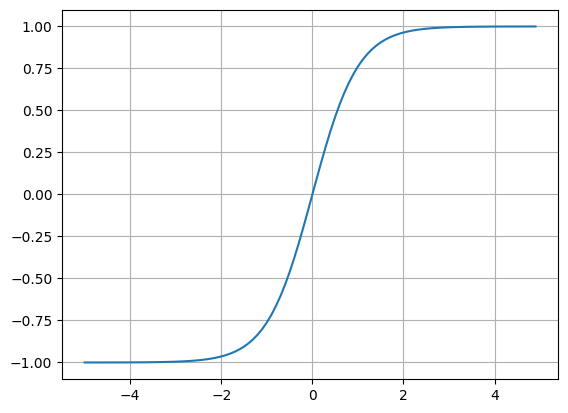

In [19]:
plt.plot(xs, np.tanh(xs))
plt.grid()

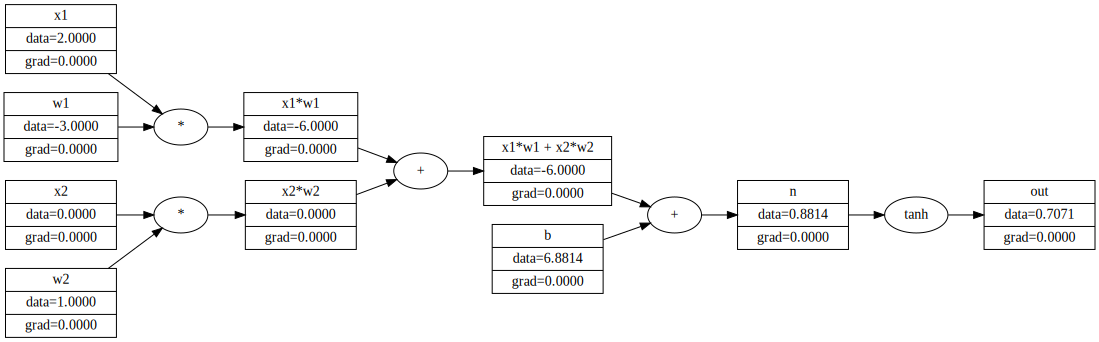

In [20]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label = 'out'
draw_dot(o)

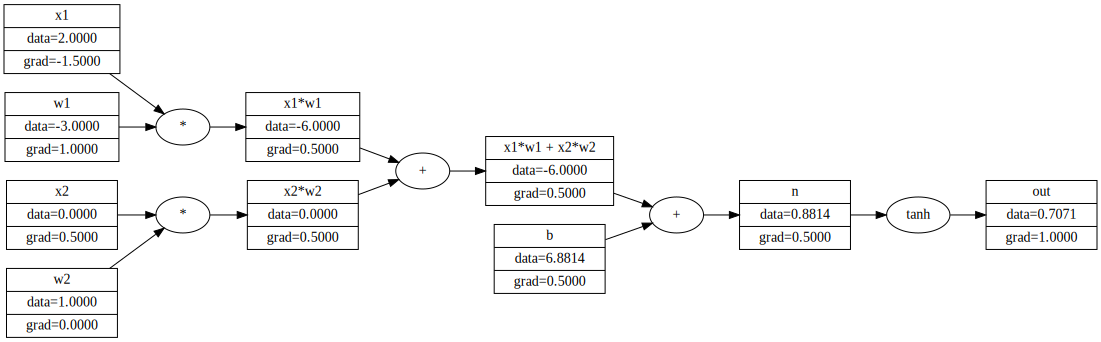

In [21]:
o.backward()
draw_dot(o)

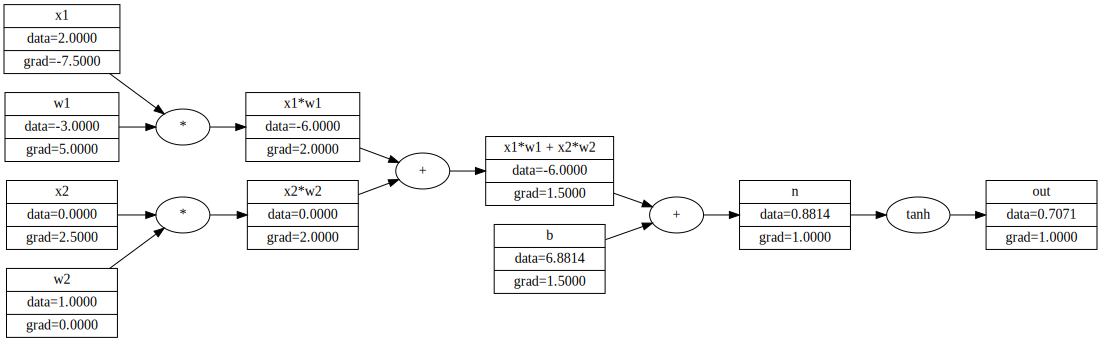

In [22]:
# topological sort of nodes
topo = []
visited = set()
def build_topo(v):
    visited.add(v)
    for child in v._prev:
        build_topo(child)
    topo.append(v)
build_topo(o)

# _backprop through nodes
o.grad = 1.0
for node in reversed(topo):
    node._backward()
draw_dot(o)

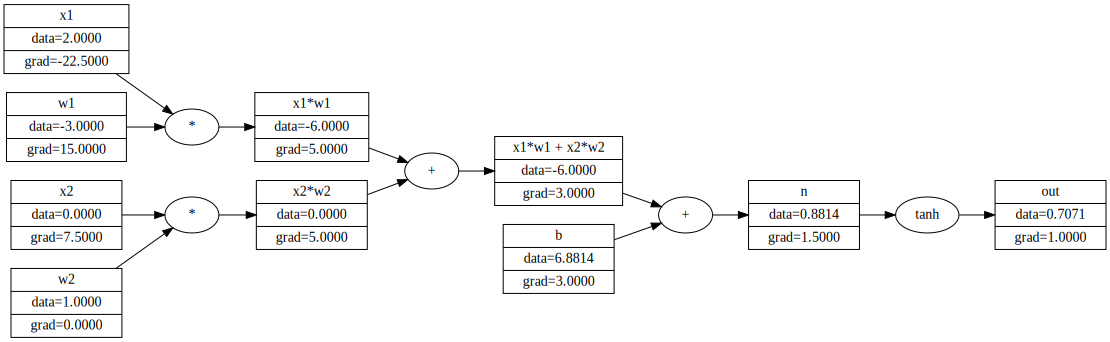

In [23]:
# manual calls of _backward
o.grad = 1.0
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
draw_dot(o)

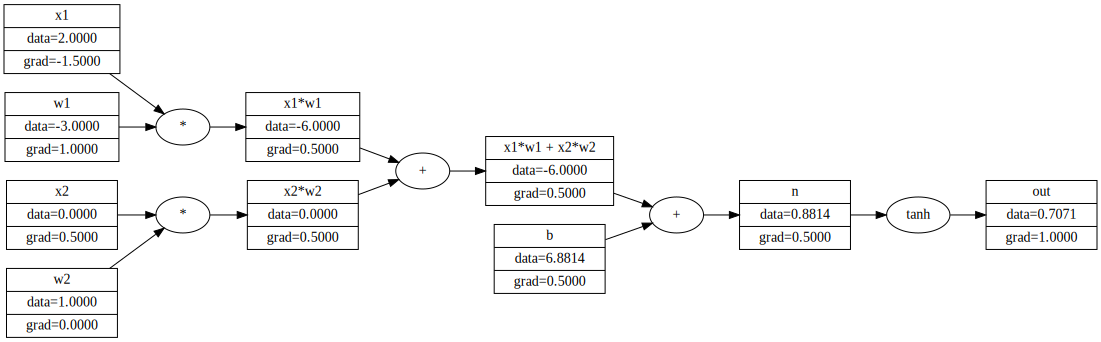

In [24]:
# manual backprop
o.grad = 1.0
n.grad = 1-o.data**2
b.grad = n.grad * 1.0
x1w1x2w2.grad = n.grad * 1.0
x1w1.grad = x1w1x2w2.grad * 1.0
x2w2.grad = x1w1x2w2.grad * 1.0
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data
draw_dot(o)

### solvign problem with gradient overriding
gradient was overrode in the nodes used multiple times before changning `=` to `+=` in all the `_backward` functions

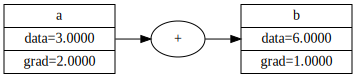

In [25]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

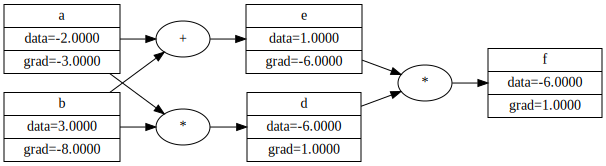

In [26]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

video timestamp: 1:27:05